<a href="https://colab.research.google.com/github/victoruwazurike1/human_activity_recognition/blob/main/Human_Activity_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook we are going to use Long short-term memory(LSTM), to learn complex features from raw accelerometer signal to be able to differentiate between common human activities.

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [21]:
columns = ['user', 'activity', 'timestamp', 'x-axis', 'y-axis', 'z-axis']
df_har = pd.read_csv('WISDM_ar_v1.1_raw.txt', header=None, names=columns)

Let us see what the dataset looks like

In [18]:
df_har.head(5)

,user,activity,timestamp,x-axis,y-axis,z-axis
0,33,Jogging,49105962326000,-0.694638,12.680544,0.50395286;
1,33,Jogging,49106062271000,5.012288,11.264028,0.95342433;
2,33,Jogging,49106112167000,4.903325,10.882658,-0.08172209;
3,33,Jogging,49106222305000,-0.612916,18.496431,3.0237172;
4,33,Jogging,49106332290000,-1.184970,12.108489,7.205164;


In [22]:
# We will remove null values
# df_har = df_har.dropna() 
df_har.shape

(956457, 6)

In [23]:
# We will transform the x-axis to float value
df_har['z-axis'] = df_har['z-axis'].str.replace(';', '')
df_har['z-axis'] = df_har['z-axis'].apply(lambda x: float(x))

In [24]:
# We will drop rows where timestamp is 0
df = df_har[df_har['timestamp'] != 0]

In [25]:
# Now we will arrange data in ascending order of user and timestamp
df = df.sort_values(by = ['user', 'timestamp'], ignore_index=True)

In [26]:
df.shape
# df.head(5)

(943615, 6)

In [27]:
df.head(5)

,user,activity,timestamp,x-axis,y-axis,z-axis
0,1,Walking,4.991922e+12,0.69,10.80,-2.03
1,1,Walking,4.991972e+12,6.85,7.44,-0.50
2,1,Walking,4.992022e+12,0.93,5.63,-0.50
3,1,Walking,4.992072e+12,-2.11,5.01,-0.69
4,1,Walking,4.992122e+12,-4.59,4.29,-1.95


Time for Exploratory Data Analysis

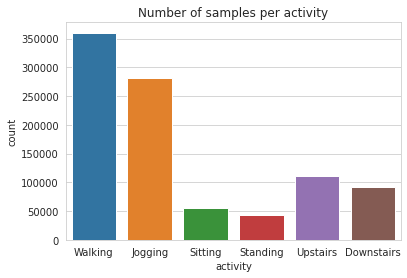

In [28]:
# We will analyse the class label distribution
sns.set_style('whitegrid')
sns.countplot(data = df, x='activity')
plt.title('Number of samples per activity')
plt.show()

From the above countplot it is obvious that there is a class imbalance as most of tthe samples ha the class-label 'Walking' and 'Jogging'

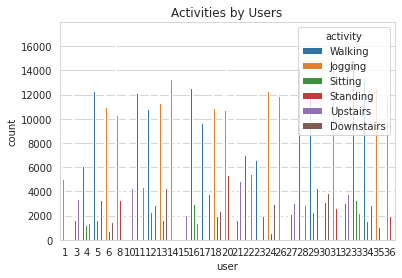

In [29]:
# We will see how the individual users are contributing to each activity
sns.countplot(x = 'user', hue='activity', data=df)
plt.title('Activities by Users')
plt.show()

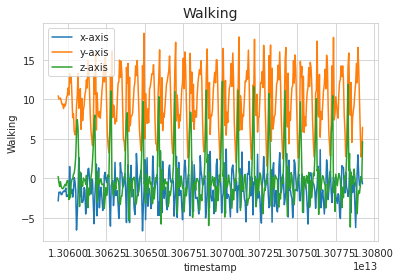

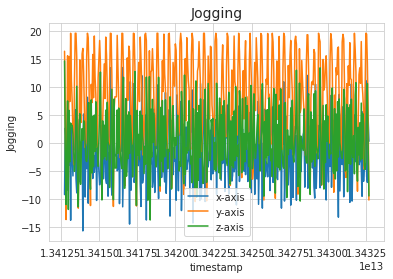

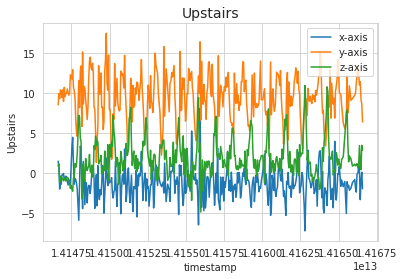

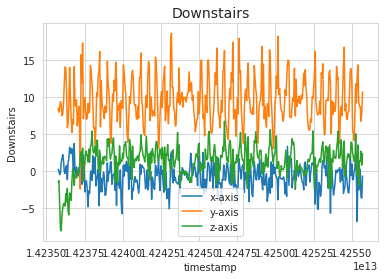

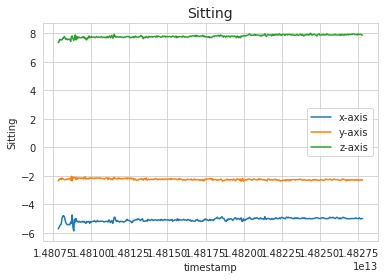

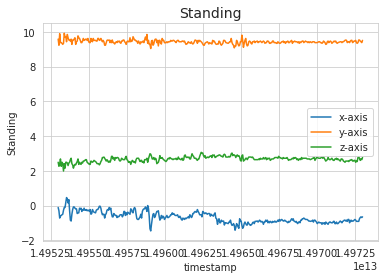

In [ ]:
# Let us go a step ahead to see how the signal values in each of the x, y, z dimensions vary with time
activities = ['Walking', 'Jogging', 'Upstairs', 'Downstairs', 'Sitting', 'Standing' ]
for i in activities:
  data36 = df[(df['user'] == 36 ) & (df['activity'] == i)][:400]
  sns.lineplot(y = 'x-axis', x = 'timestamp', data = data36)
  sns.lineplot(y = 'y-axis', x = 'timestamp', data = data36)
  sns.lineplot(y = 'z-axis', x = 'timestamp', data = data36)
  plt.legend(['x-axis', 'y-axis', 'z-axis'])
  plt.ylabel(i)
  plt.title(i, fontsize = 14)
  plt.show()

Note that above for visualization we considered a subset of 400 samples which is equivalent to 20 seconds of activity(as the frequency of data collection was 20Hz). These signals can be modeled as time-series data. Which brings us to the main business- Training an LSTM Network

In [30]:
# Now we are going to prepare the data for the LSTM network
random_seed = 42
n_time_steps = 50
n_features = 3
step = 10
n_classes = 6
n_epochs = 50
batch_size = 1024
learning_rate = 0.0025
l2_loss = 0.0015

segments = []
labels = []

from scipy import stats

for i in range(0, df.shape[0] - n_time_steps, step):
  xs = df['x-axis'].values[i: i + 50]
  ys = df['y-axis'].values[i: i + 50]
  zs = df['z-axis'].values[i: i + 50]
  label = stats.mode(df['activity'][i: i + 50])[0][0]
  segments.append([xs, ys, zs])
  labels.append(label)

In [31]:
# We will reshape the segments(which is a list of arrays) to a list
reshaped_segments = np.asarray(segments, dtype = np.float32).reshape(-1, n_time_steps, n_features)
labels = np.asarray(pd.get_dummies(labels), dtype = np.float32)
reshaped_segments.shape

(94357, 50, 3)

Now we have 108532 sequences of 200 rows, each containing x, y and z data. Our dataset has been drastically reduced in size  

In [32]:
# We will split our data into train and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(reshaped_segments, labels, test_size = 0.2, random_state = random_seed)


In [33]:
# Now we are going to build the model architecture
from keras.models import Sequential
from keras.layers import LSTM, Dense, Flatten, Dropout

model = Sequential()
# RNN layer
model.add(LSTM(units = 128, input_shape = (X_train.shape[1], X_train.shape[2])))
# Dropout layer
model.add(Dropout(0.5))
# Dense layer with ReLu
model.add(Dense(units = 64, activation = 'relu'))
# Softmax layer
model.add(Dense(y_train.shape[1], activation = 'softmax'))
# Compile model
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
# Let us see what the model summary looks like
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 128)               67584     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 390       
Total params: 76,230
Trainable params: 76,230
Non-trainable params: 0
_________________________________________________________________


We can see that we have 76,230 trainable parameters. Because of so many trainable parameters the model tends to overfit easily which is why we added a Dropout layer.

In [34]:
# Now we are going to train our model for 50 epochs and keep track of accuracy and error on the validation set
history = model.fit(X_train, y_train, epochs = n_epochs, validation_split=0.20, batch_size=batch_size, verbose=1)


Epoch 1/50
59/59 [==============================] - 27s 64ms/step - loss: nan - accuracy: 0.1592 - val_loss: nan - val_accuracy: 0.1009
Epoch 2/50
59/59 [==============================] - 3s 43ms/step - loss: nan - accuracy: 0.0964 - val_loss: nan - val_accuracy: 0.1009
Epoch 3/50
59/59 [==============================] - 3s 42ms/step - loss: nan - accuracy: 0.0972 - val_loss: nan - val_accuracy: 0.1009
Epoch 4/50
59/59 [==============================] - 3s 44ms/step - loss: nan - accuracy: 0.0965 - val_loss: nan - val_accuracy: 0.1009
Epoch 5/50
59/59 [==============================] - 3s 43ms/step - loss: nan - accuracy: 0.0977 - val_loss: nan - val_accuracy: 0.1009
Epoch 6/50
59/59 [==============================] - 2s 42ms/step - loss: nan - accuracy: 0.0948 - val_loss: nan - val_accuracy: 0.1009
Epoch 7/50
59/59 [==============================] - 3s 45ms/step - loss: nan - accuracy: 0.0964 - val_loss: nan - val_accuracy: 0.1009
Epoch 8/50
59/59 [==============================] - 3s

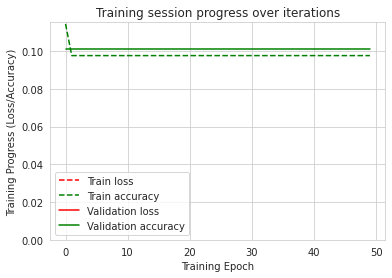

In [35]:
# We will plot training and validation accuracy  and cross-entropy loss against a number of epochs
plt.plot(np.array(history.history['loss']), 'r--', label = 'Train loss')
plt.plot(np.array(history.history['accuracy']), 'g--', label = 'Train accuracy')
plt.plot(np.array(history.history['val_loss']), 'r-', label = 'Validation loss')
plt.plot(np.array(history.history['val_accuracy']), 'g-', label = 'Validation accuracy')
plt.title('Training session progress over iterations')
plt.legend(loc ='lower left')
plt.ylabel('Training Progress (Loss/Accuracy)')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.show()

In [ ]:
# Now we will assess the performance of the trained model on the test dataset
loss, accuracy = model.evaluate(X_test, y_test, batch_size = batch_size, verbose = 1)
print('Test Accuracy :', accuracy)
print('Test Loss: ', loss)

22/22 [==============================] - 0s 10ms/step - loss: nan - accuracy: 0.0897
Test Accuracy : 0.08974063396453857
Test Loss:  nan


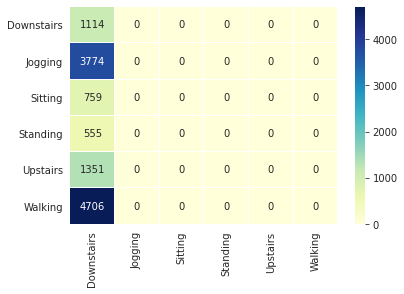

In [ ]:
# Now we are going to use the confusion matrix
from sklearn import metrics
predictions = model.predict(X_test)
class_labels = ['Downstairs', 'Jogging', 'Sitting', 'Standing', 'Upstairs', 'Walking']
max_test = np.argmax(y_test, axis = 1)
max_predictions = np.argmax(predictions, axis =1)
confusion_matrix = metrics.confusion_matrix(max_test, max_predictions)
sns.heatmap(confusion_matrix, xticklabels=class_labels, yticklabels=class_labels, annot=True, linewidths=0.1, fmt = 'd', cmap = 'YlGnBu')